In [1]:
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS token

all_categories = []
category_lines = {}

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

for filename in glob.glob('./data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    category_lines[category] = [unicode_to_ascii(line) for line in lines]

n_categories = len(all_categories)

In [2]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # Ruft den Konstruktor der übergeordneten nn.Module-Klasse auf.
        super(RNN, self).__init__()
        # Speichert die Größe der versteckten Schicht (des "Gedächtnisses").
        self.hidden_size = hidden_size

        # === Definition der Schichten ===
        # Lineare Schicht, die den neuen hidden state berechnet.
        # Der Input ist eine Kombination aus Kategorie, dem aktuellen Buchstaben und dem letzten hidden state.
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        
        # Lineare Schicht, die einen vorläufigen Output berechnet.
        # Sie erhält denselben kombinierten Input wie die i2h-Schicht.
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        
        # Eine zusätzliche lineare Schicht, die den finalen Output verfeinert,
        # indem sie den neuen hidden state und den vorläufigen Output kombiniert.
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        
        # Dropout-Schicht zur Regularisierung, um Overfitting zu reduzieren.
        self.dropout = nn.Dropout(0.1)
        
        # LogSoftmax-Aktivierungsfunktion für die finale Ausgabe.
        self.softmax = nn.LogSoftmax(dim=1)

    # Definiert den Datenfluss für einen einzelnen Zeitschritt.
    def forward(self, category, input, hidden):
        # Kombiniert die drei Eingangs-Tensoren (Kategorie, aktueller Buchstabe, letzter hidden state) zu einem Vektor.
        input_combined = torch.cat((category, input, hidden), 1)
        
        # Berechnet den neuen hidden state ("Gedächtnis") für den nächsten Zeitschritt.
        hidden = self.i2h(input_combined)
        
        # Berechnet einen vorläufigen Output.
        output = self.i2o(input_combined)
        
        # Kombiniert den neuen hidden state mit dem vorläufigen Output für eine finale Verfeinerung.
        output_combined = torch.cat((hidden, output), 1)
        
        # Berechnet den finalen Output mit der o2o-Schicht.
        output = self.o2o(output_combined)
        
        # Wendet Dropout auf den Output an.
        output = self.dropout(output)
        
        # Wendet die LogSoftmax-Funktion an, um Log-Wahrscheinlichkeiten zu erhalten.
        output = self.softmax(output)
        
        # Gibt die Vorhersage (nächster Buchstabe) und den neuen hidden state zurück.
        return output, hidden

    # Hilfsfunktion, um einen leeren (mit Nullen gefüllten) hidden state zu Beginn zu erstellen.
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [3]:
def random_choice(l):
    return l[random.randint(0, len(l) - 1)]

def random_training_pair():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    return category, line

def category_tensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def input_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def target_tensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

def random_training_example():
    category, line = random_training_pair()
    category_t = category_tensor(category)
    input_line_t = input_tensor(line)
    target_line_t = target_tensor(line)
    return category_t, input_line_t, target_line_t

5000 5% (00:09) Loss: 3.1475
10000 10% (00:20) Loss: 3.0189
15000 15% (00:29) Loss: 2.5008
20000 20% (00:39) Loss: 2.3162
25000 25% (00:49) Loss: 2.2361
30000 30% (00:59) Loss: 1.8440
35000 35% (01:09) Loss: 2.1415
40000 40% (01:19) Loss: 4.2505
45000 45% (01:29) Loss: 2.9024
50000 50% (01:39) Loss: 2.0822
55000 55% (01:49) Loss: 2.4876
60000 60% (01:59) Loss: 2.7644
65000 65% (02:09) Loss: 1.7927
70000 70% (02:19) Loss: 2.4118
75000 75% (02:29) Loss: 3.8179
80000 80% (02:39) Loss: 2.9131
85000 85% (02:49) Loss: 3.9246
90000 90% (02:59) Loss: 2.5753
95000 95% (03:09) Loss: 2.8893
100000 100% (03:19) Loss: 2.5245


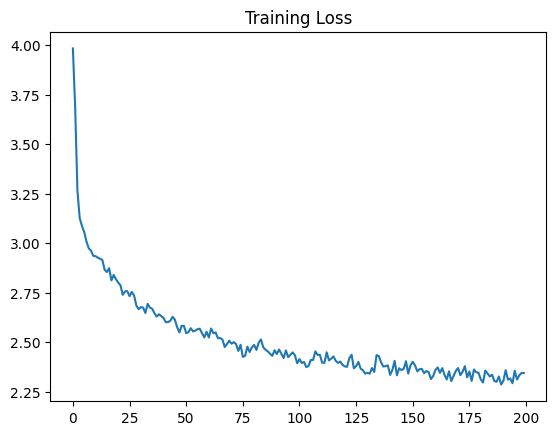

In [4]:
learning_rate = 0.0005
rnn = RNN(n_letters, 128, n_letters)
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

def train(category_tensor, input_line_tensor, target_line_tensor):
    # Fügt dem Target-Tensor eine zusätzliche Dimension hinzu.
    # Dies ist eine technische Notwendigkeit, damit die Form für die Verlustfunktion `criterion` korrekt ist.
    target_line_tensor.unsqueeze_(-1)
    
    # Initialisiert den hidden state des RNNs zu Beginn jeder Sequenz mit Nullen.
    hidden = rnn.init_hidden()

    # Setzt die Gradienten aller Modellparameter auf null.
    # Dies ist notwendig, da PyTorch Gradienten standardmäßig akkumuliert.
    rnn.zero_grad()

    # Initialisiert eine Variable, um den Gesamtverlust für die aktuelle Sequenz zu speichern.
    loss = 0

    # Hauptschleife, die jeden Buchstaben der Eingabesequenz einzeln verarbeitet.
    for i in range(input_line_tensor.size(0)):
        # Führt einen Forward-Pass für den aktuellen Buchstaben durch.
        # Übergibt die Kategorie, den Buchstaben und den letzten hidden state, um den neuen Output und hidden state zu erhalten.
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        
        # Berechnet den Verlust für diesen einen Zeitschritt:
        # Vergleicht die Vorhersage des Modells (output) mit dem tatsächlichen nächsten Buchstaben (target_line_tensor[i]).
        l = criterion(output, target_line_tensor[i])
        
        # Addiert den Verlust des aktuellen Schritts zum Gesamtverlust der Sequenz.
        loss += l

    # Nach der Schleife wird der Backpropagation-Schritt für den aufsummierten Verlust der gesamten Sequenz ausgeführt.
    # PyTorch berechnet automatisch die Gradienten für alle Zeitschritte ("backpropagation through time").
    loss.backward()
    
    # Der Optimizer aktualisiert die Gewichte des Modells basierend auf den berechneten Gradienten.
    optimizer.step()

    # Gibt den Output des letzten Zeitschritts und den durchschnittlichen Verlust pro Buchstabe zurück.
    return output, loss.item() / input_line_tensor.size(0)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*random_training_example())
    total_loss += loss

    if iter % print_every == 0:
        elapsed = time.time() - start
        print(f'{iter} {iter / n_iters * 100:.0f}% ({time.strftime("%M:%S", time.gmtime(elapsed))}) Loss: {loss:.4f}')

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

plt.figure()
plt.plot(all_losses)
plt.title('Training Loss')
plt.show()

In [291]:
max_length = 20

def sample(category, start_letter='A'):
    with torch.no_grad():
        category_t = category_tensor(category)
        input_t = input_tensor(start_letter)
        hidden_t = rnn.init_hidden()

        output_name = start_letter

        for i in range(max_length - 1):
            output, hidden_t = rnn(category_t, input_t[0], hidden_t)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input_t = input_tensor(letter)

        return output_name

def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'P')
samples('German', 'H')
samples('Italian', 'P')
samples('Spanish', 'G')
samples('Chinese', 'W')

Parien
Harer
Perie
Gare
Wan
